In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import warnings
from sklearn.metrics import mean_squared_error
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import ipywidgets as widgets
from ipywidgets import interact

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries as cLib

In [63]:
df = pd.read_csv('../Datasets/cleaned_Productivity.csv')
df.drop('mean', axis=1, inplace=True)
df_formatted = pd.melt(df, id_vars = ['LOCATION'], var_name = 'YEAR', value_name= 'PRODUCTIVITY')
df_formatted = df_formatted.sort_values(['LOCATION', 'YEAR'], ascending=[True, True])
df_formatted = df_formatted.reset_index(drop=True)
df_formatted['YEAR'] = pd.to_numeric(df_formatted['YEAR'])

# Drop values before 2005
df_formatted = df_formatted[df_formatted['YEAR'] >= 2005]

# Per country

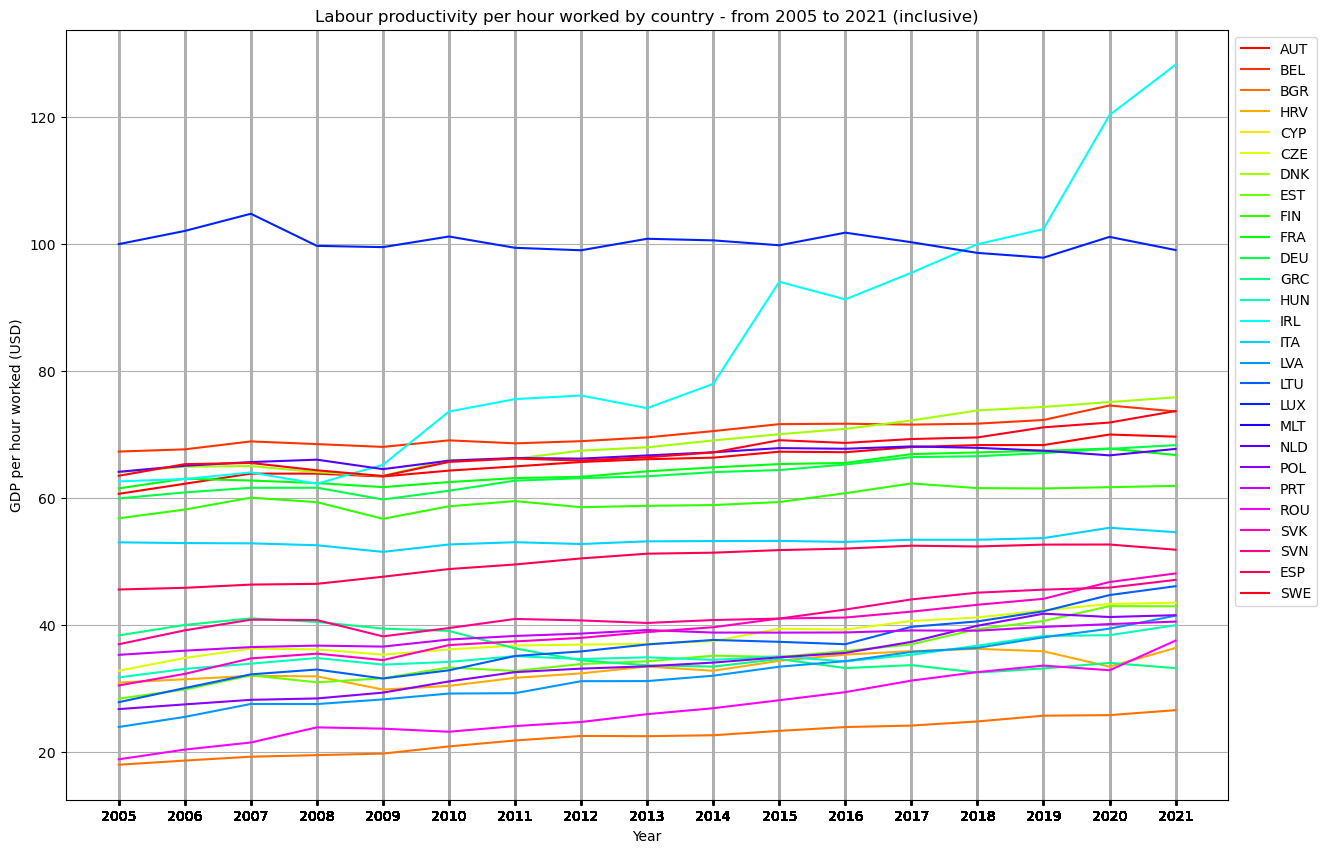

In [ ]:
# Plot the data
plt.subplots(figsize=(15, 10))
countries = cLib.get_countries()
colors = plt.cm.hsv(np.linspace(0, 1, len(countries)))
years_xticks = [int(year) for year in df_formatted['YEAR']]

for i, country in enumerate(countries):
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    plt.plot(country_data['YEAR'], country_data['PRODUCTIVITY'], color=colors[i], label=country_code)
    
plt.grid()
# plt.xticks(years_xticks)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by country - from 2005 to 2021 (inclusive)")
plt.show()

## Exponential smoothing

In [126]:
# REFERENCE: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
def plot_smoothed_data(name, series, index):
    # Smooth series and predict 5 years ahead
    pred_date_start = 2021
    pred_date_end = 2021 + 5
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series, initialization_method="estimated").fit()
    forecast = fit.forecast(5)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series,
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES forecast', linestyle='dotted')
    plt.plot(index, exp_smoothed, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label="Holt's Linear Trend forecast", linestyle='dotted')
    plt.axvline(x=pd.to_datetime(2021, format="%Y"), color='gray', linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(f"Labour productivity per hour worked by {name} - from 2005 to 2021 (inclusive)")
    plt.show()

In [66]:
# Get the mean data for each year
path = "../Datasets/cleaned_Productivity.csv"
df_labour = pd.read_csv(path)
df_labour.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
df_labour.drop(columns=['mean'], inplace=True)
df_labour = df_labour[df_labour['LOCATION'].isin(cLib.get_alpha_3_list())]
df_labour.reset_index(drop=True, inplace=True)
df_labour_mean = df_labour.mean(numeric_only=True, axis=0)
df_labour_mean = pd.DataFrame(df_labour_mean, columns=['PRODUCTIVITY'])
df_labour_mean.index.freq = 'AS'

# Drop values before 2005
df_labour_mean = df_labour_mean[df_labour_mean.index >= 2005]

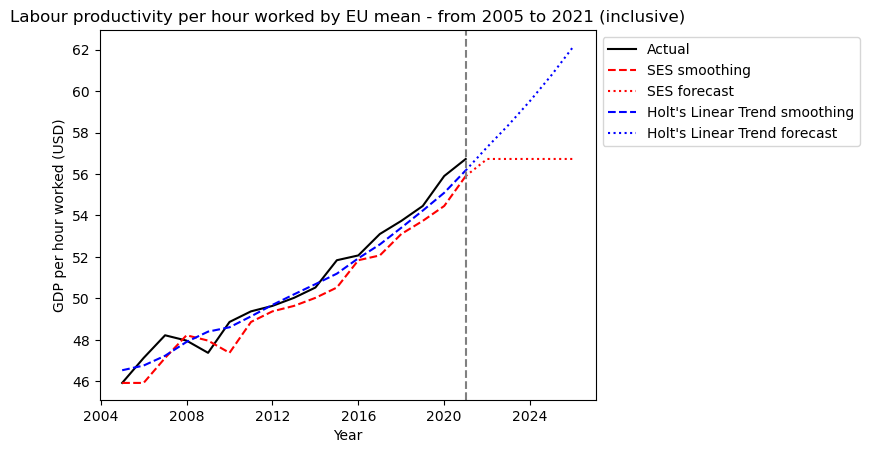

In [127]:
# Exponential smoothing
index = pd.date_range(start='2005', end='2021', freq='AS')
labour_mean_series = pd.Series(df_labour_mean['PRODUCTIVITY'].values, index=index)
plot_smoothed_data("EU mean", labour_mean_series, index)

Due to the horizontal line from the SES prediction (SES assumes that the time series has an underlying constant level), it is clearly a poor choice for predicting, so the general exponential smoothing will be used instead

Let's see if we limit the time series up to 2016, can it predict accurately up to 2021?

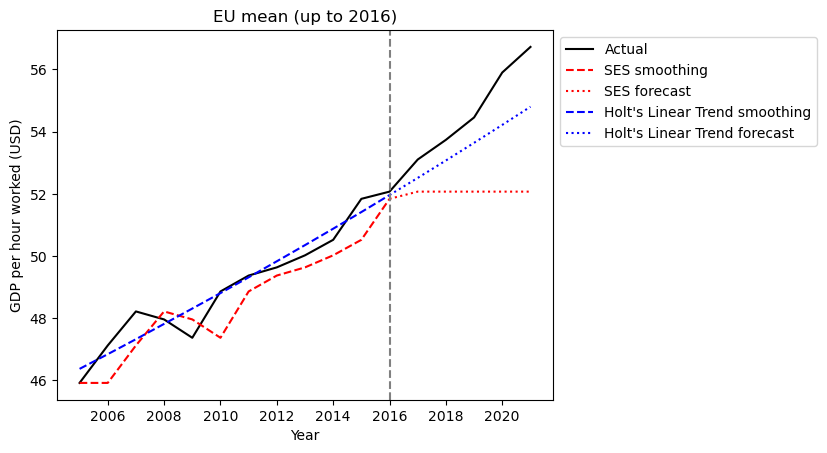

In [128]:
def plot_smoothed_data_past(title, series, index, pred_date_start=2022):
    # Smooth series and predict 5 years ahead
    pred_date_end = pred_date_start + 5
    actual_time = pred_date_start - 2005 + 1
    prediction_time = pred_date_end - pred_date_start
    index_actual = pd.date_range(start='2005', end=str(pred_date_start), freq='AS')
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series[:actual_time], initialization_method="estimated").fit()
    forecast = fit.forecast(prediction_time)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:actual_time],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index_actual, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES forecast', linestyle='dotted')
    plt.plot(index_actual, exp_smoothed, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label="Holt's Linear Trend forecast", linestyle='dotted')
    plt.axvline(x=pd.to_datetime(2016, format="%Y"), color='gray', linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(title)
    plt.show()
plot_smoothed_data_past("EU mean (up to 2016)", labour_mean_series, index, pred_date_start=2016)

Let's test on all of the countries separately

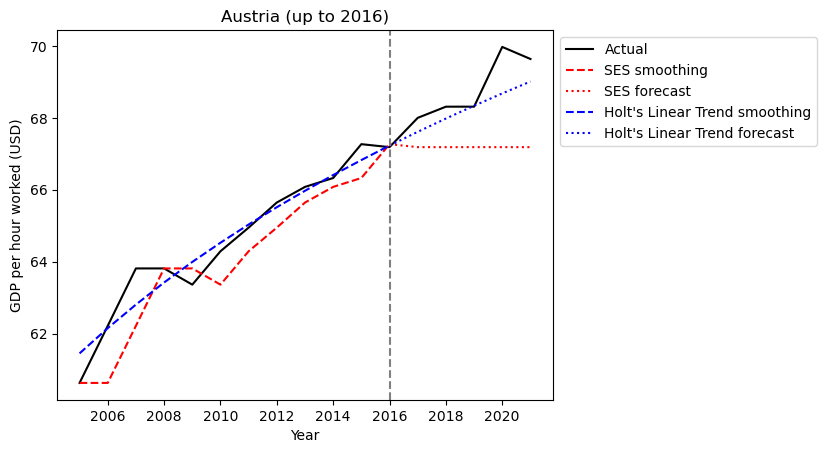

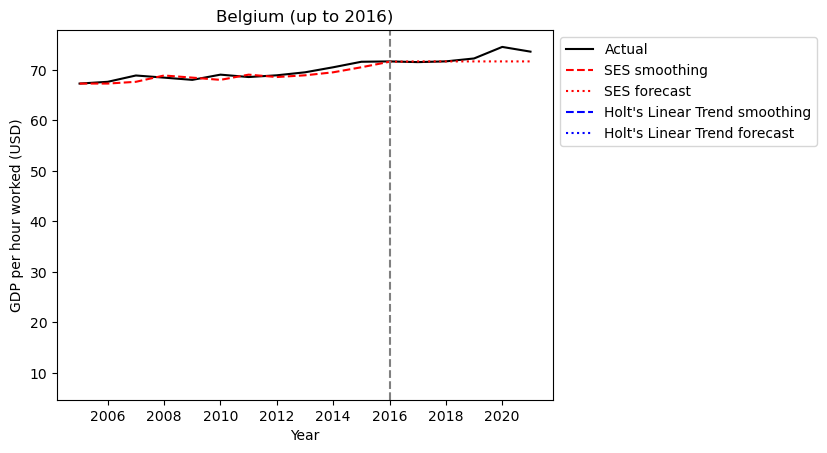

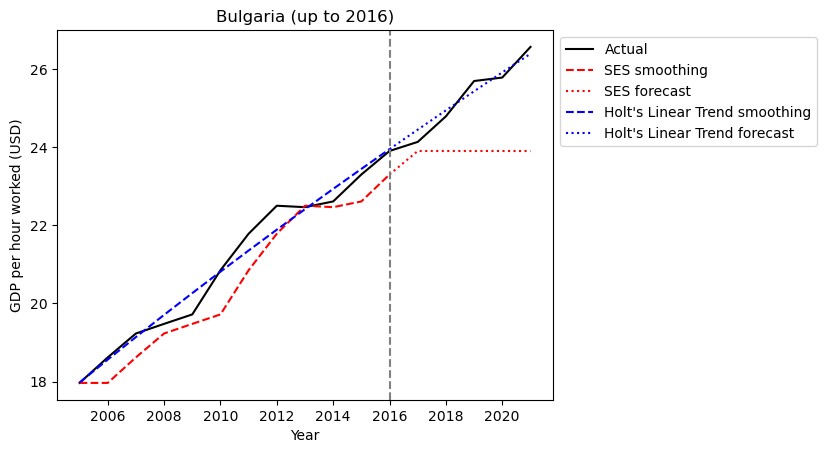

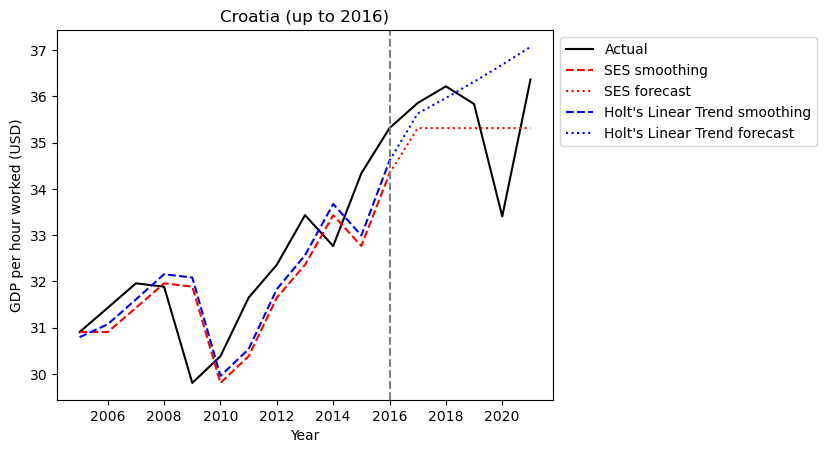

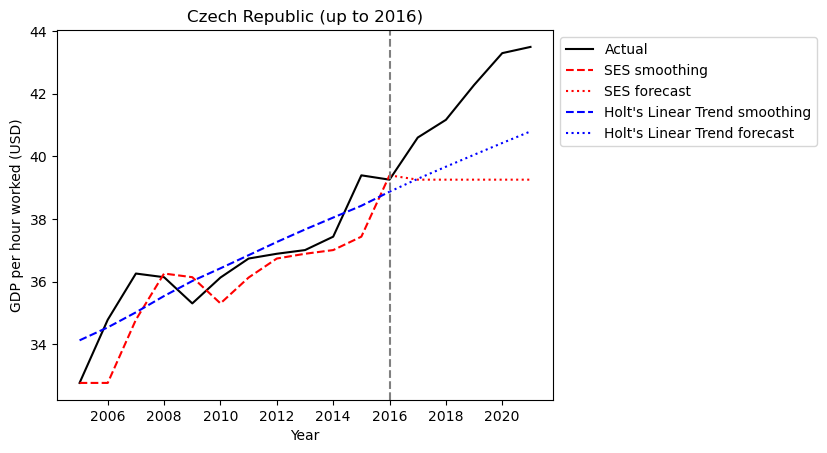

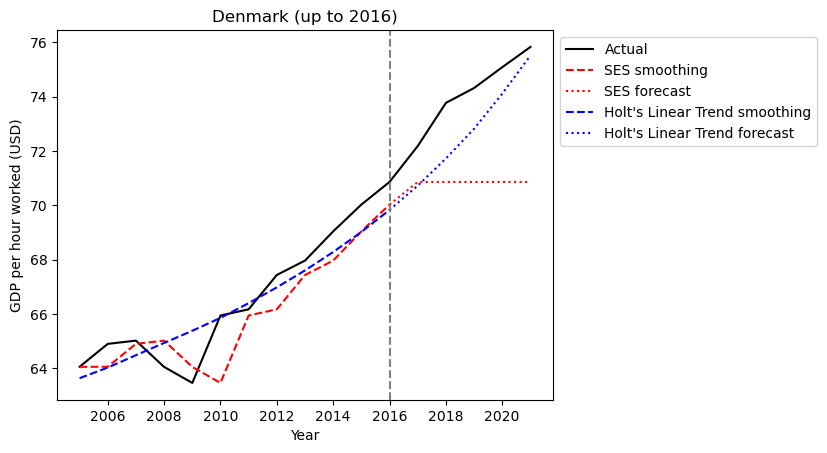

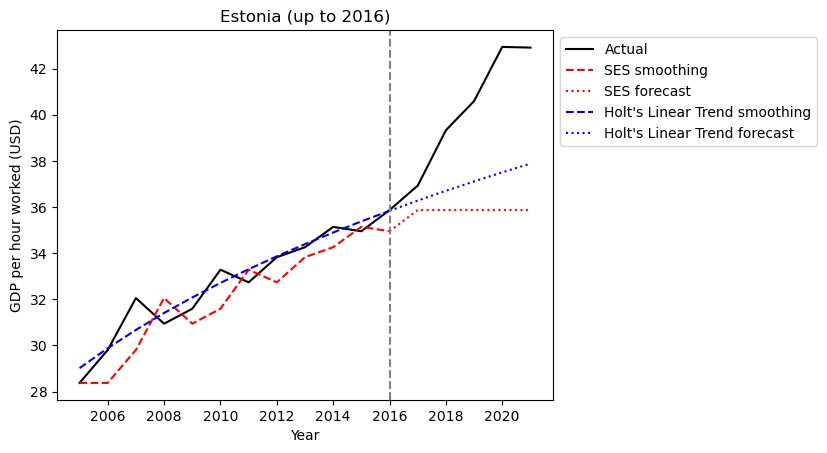

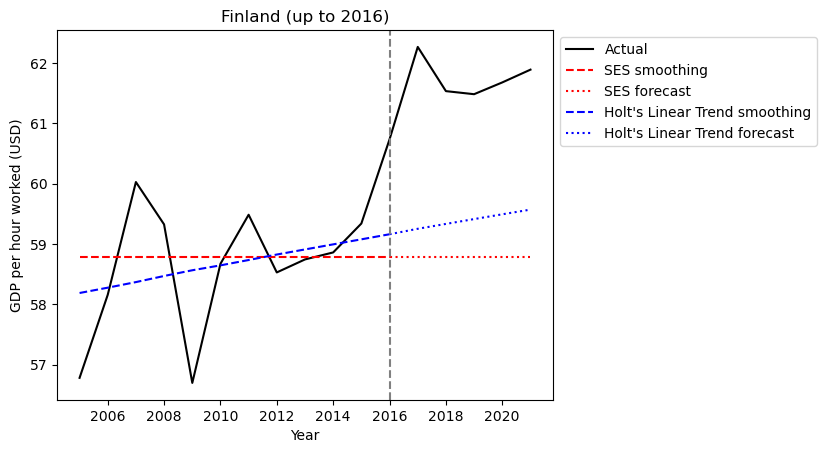

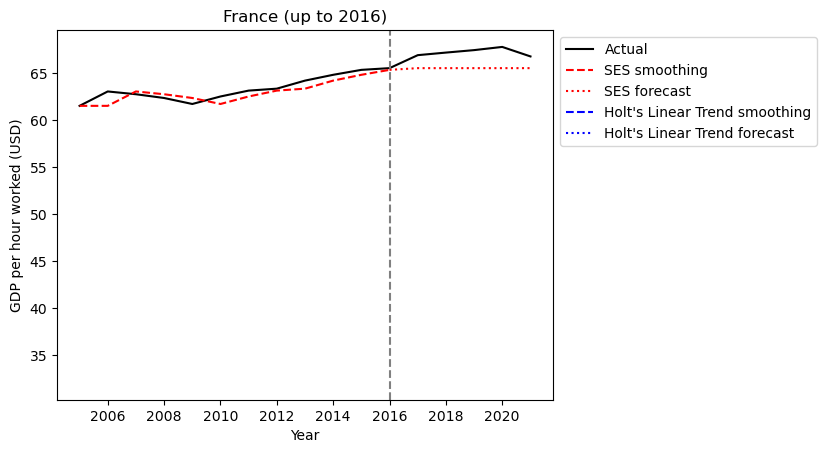

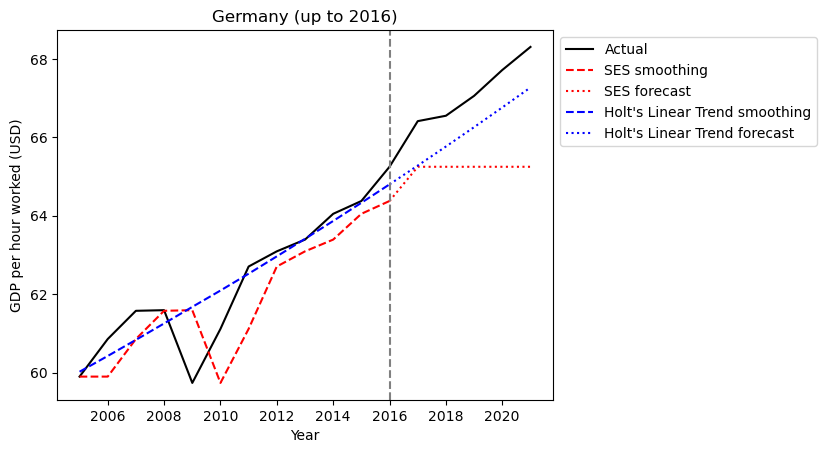

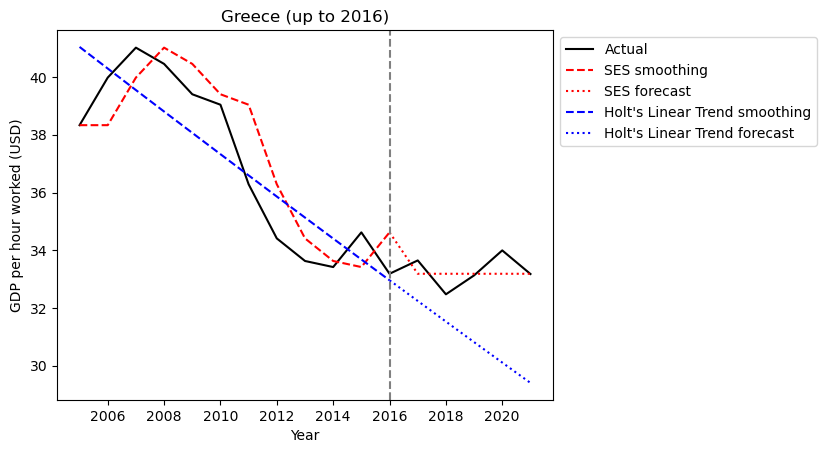

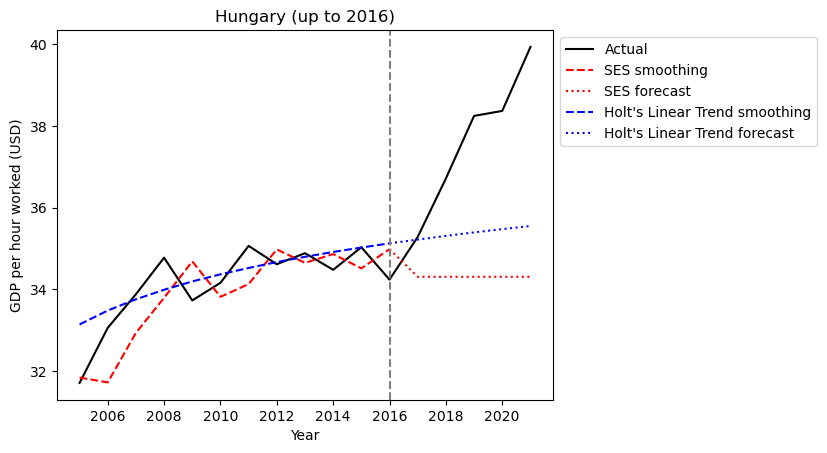

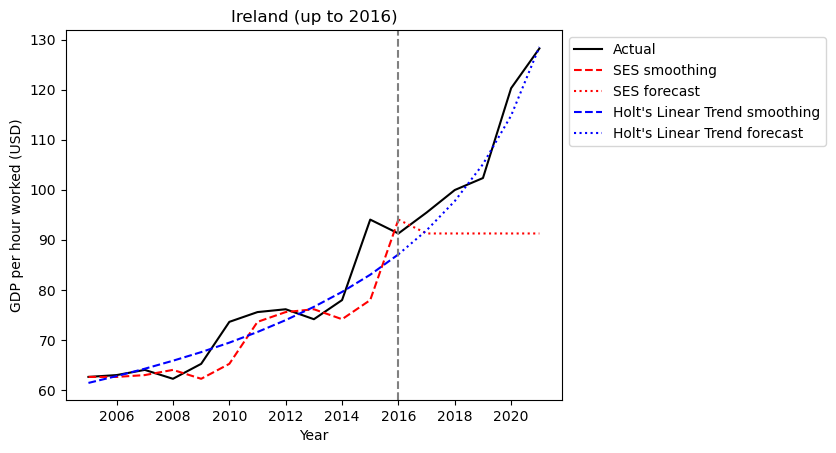

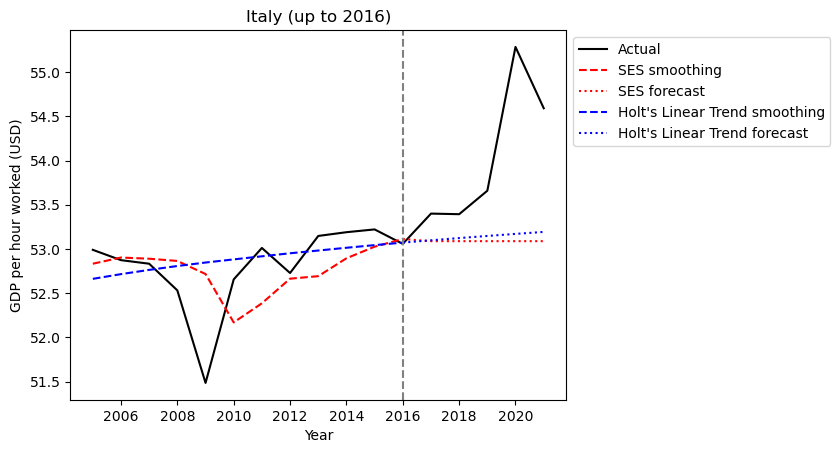

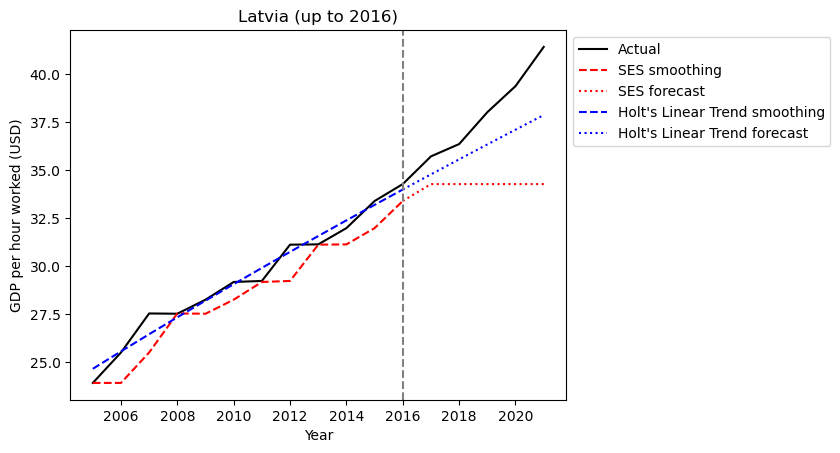

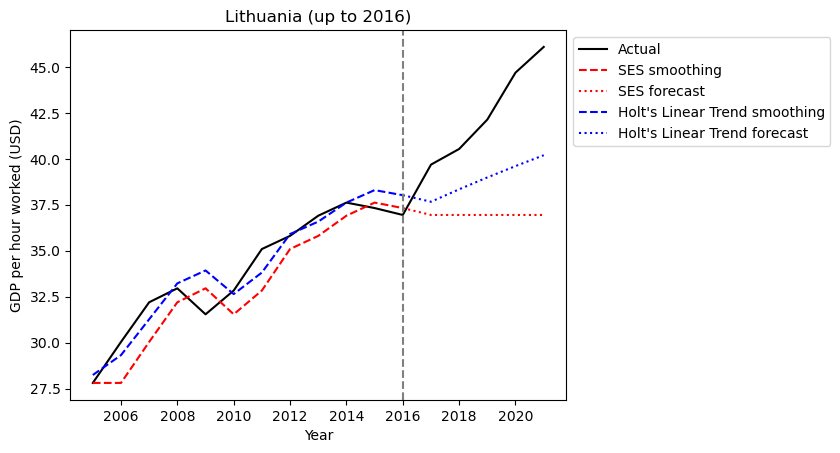

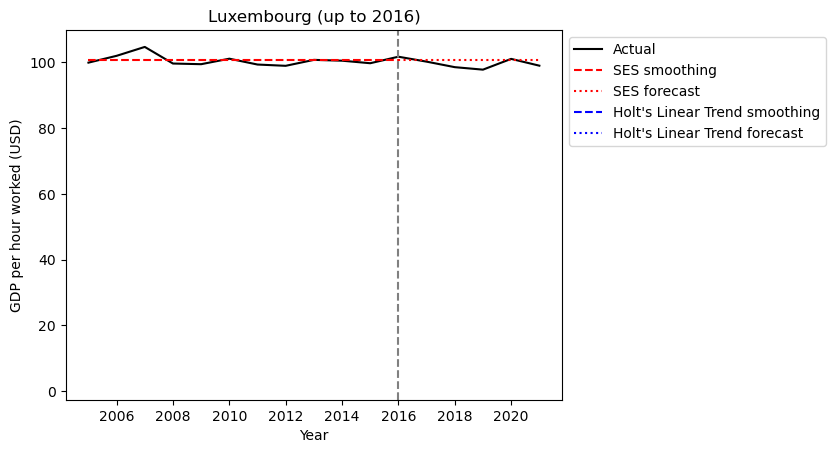

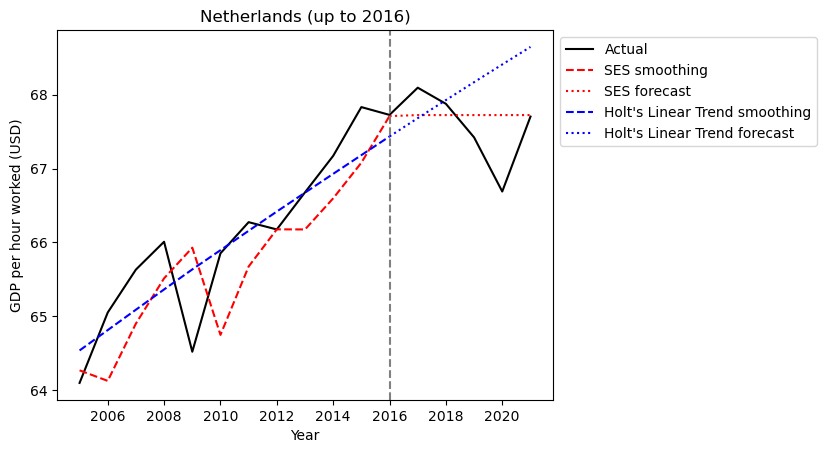

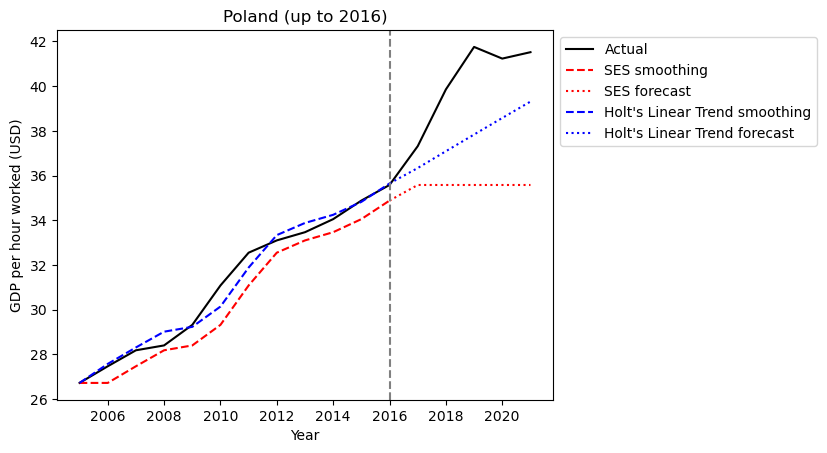

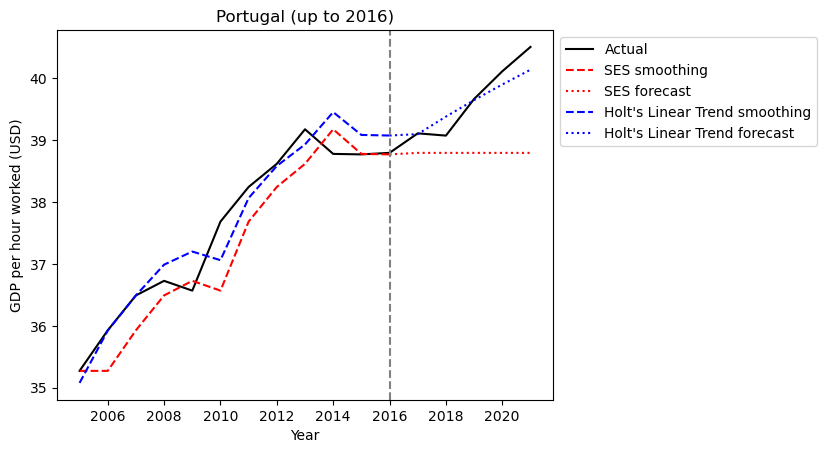

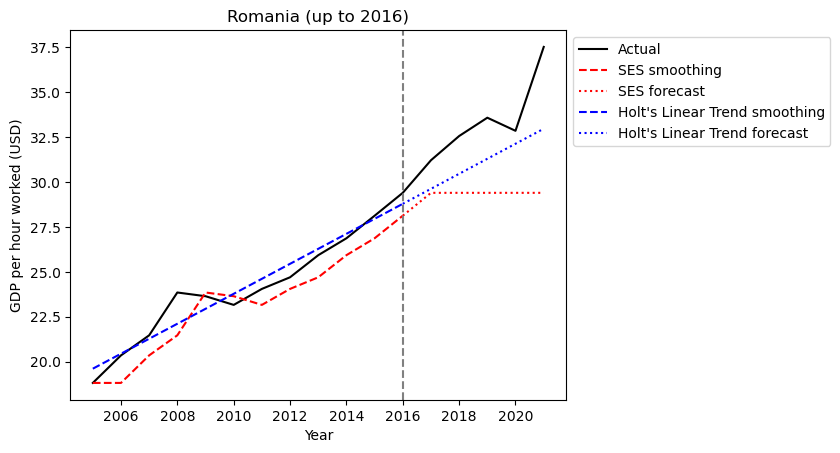

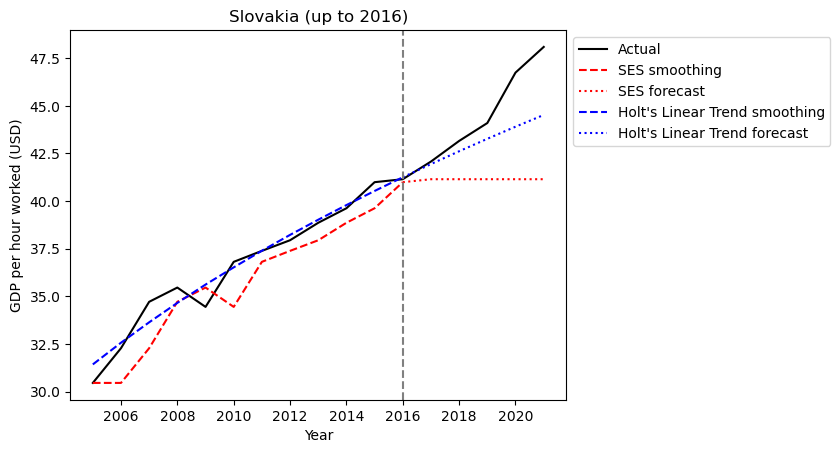

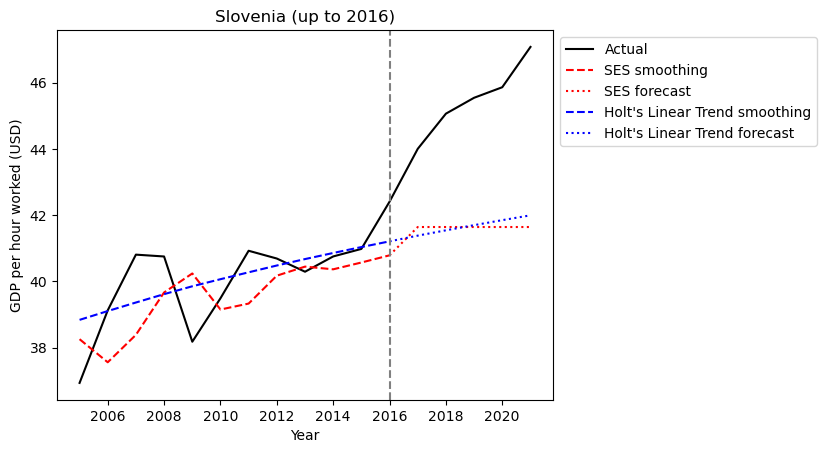

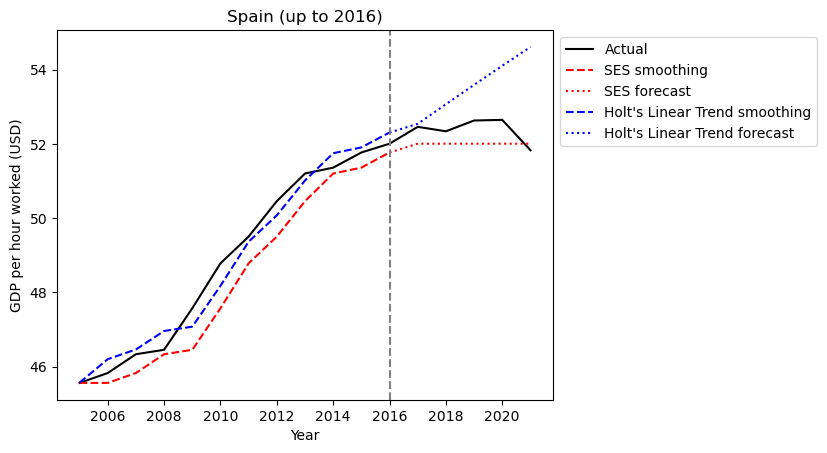

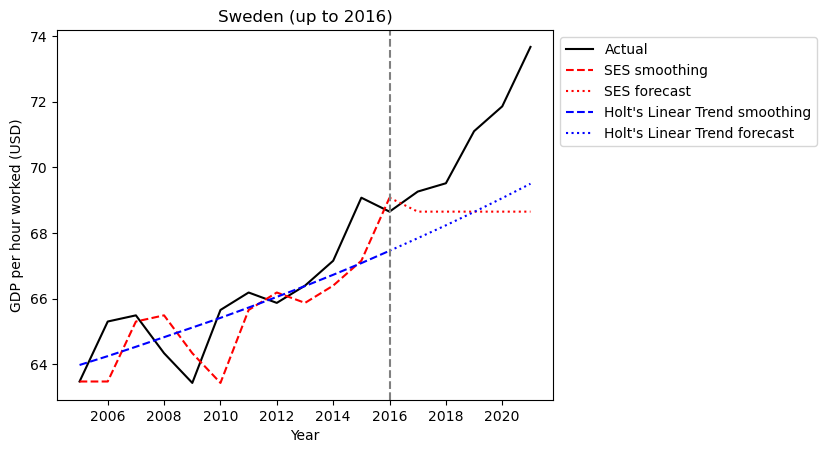

In [129]:
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2005', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    plot_smoothed_data_past(country+" (up to 2016)", country_series, index, pred_date_start=2016)

The issue with using Exponential Smoothing is that it seems to push the trends forwards in time (see 2009). So while it can do a decent job at predicting the future, it probably is not a good choice for filling in missing data.

Furthermore, it isn't that great at predicting the future, so going to look into ARIMA

## ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   17
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -15.831
Date:                Thu, 06 Apr 2023   AIC                             37.663
Time:                        21:20:41   BIC                             39.981
Sample:                    01-01-2005   HQIC                            37.782
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.051     19.780      0.000       0.901       1.099
ma.L1         -0.9925      8.182     -0.121      0.903     -17.029      15.044
sigma2         0.3530      2.848      0.124      0.9

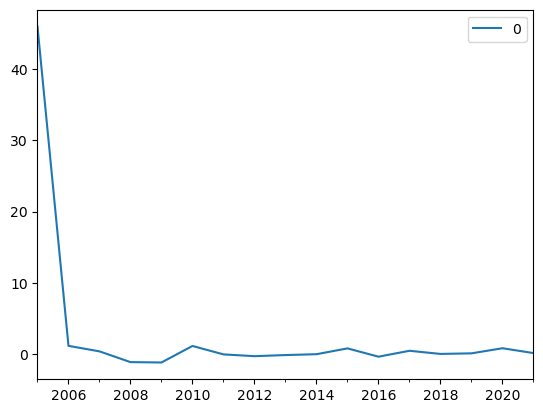

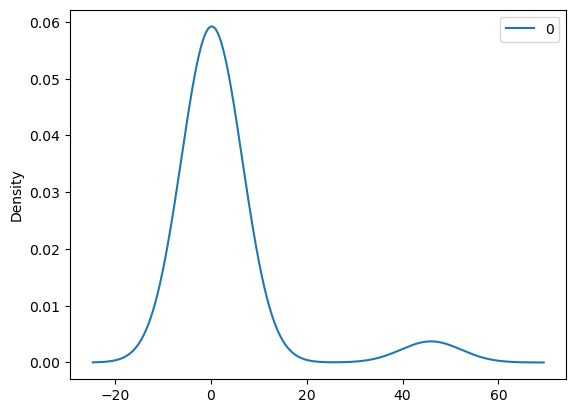

               0
count  17.000000
mean    2.857671
std    11.116885
min    -1.125830
25%    -0.087641
50%     0.153425
75%     0.848818
max    45.921124


In [70]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def plot_arima_residual_errors(series, arima_order=(1, 1, 1)):
    # ARIMA
    model = ARIMA(series, order=arima_order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # Plot density plot of residual errors
    residuals.plot(kind='kde')
    plt.show()

    print(residuals.describe())
plot_arima_residual_errors(labour_mean_series)

As seen in those graphs, looks like there shouldn't be much residual errors, only at the start, so let's try to predict the future with it

In [143]:
# Evaluate an ARIMA model using a walk-forward validation
def run_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = 2016 - 2005 + 1 # train up to and including 2016
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    results = {
        "train": train,
        "test": test,
        "predictions": predictions,
        "train_size": train_size,
        "history": history
    }
    return results

def plot_arima_model(title, X, arima_order, test_only=False):
    results = run_arima_model(X, arima_order)
    train_size = results["train_size"]
    train = results["train"]
    test = results["test"]
    predictions = results["predictions"]

    # Plot graph
    if not test_only:
        # Add the 2016 value to the predictions
        predictions = np.insert(predictions, 0, train[-1])

        plt.plot(index, X, color='black', label='Actual')
        plt.plot(index[train_size-1:], predictions, color='red', label='Predictions', linestyle='--')
        plt.axvline(x=pd.to_datetime(2016, format="%Y"), color='gray', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2005, 2022)]
        plt.plot(years[train_size:], test, color='black', label='Actual')
        plt.plot(years[train_size:], predictions, color='red', label='Predictions', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

def evaluate_arima_model(X, arima_order):
    results = run_arima_model(X, arima_order)
    test = results["test"]
    predictions = results["predictions"]
    
    # Calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Let's try to tune the parameters to get the best hyperparameters

In [139]:
# Tune the ARIMA model
# REFERENCE: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(labour_mean_series, p_values, d_values, q_values)

Best ARIMA(10, 2, 0) MSE=0.135


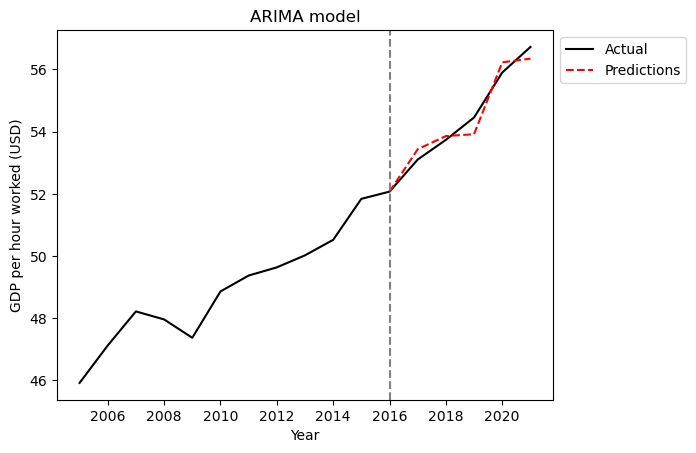

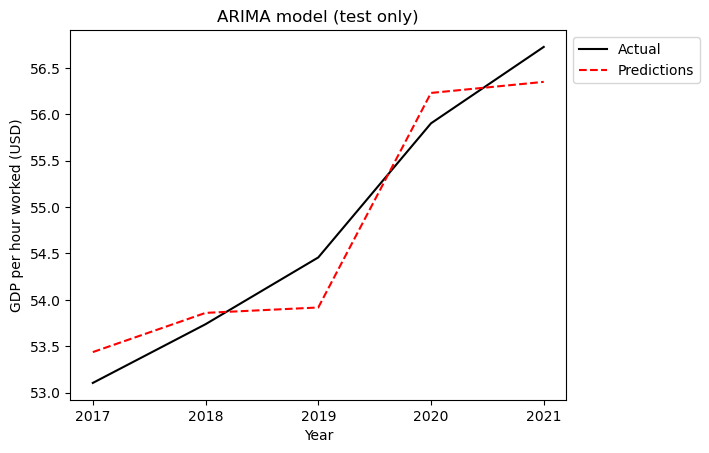

In [140]:
# Plot the best ARIMA model
plot_arima_model("ARIMA model", labour_mean_series, best_cfg)
plot_arima_model("ARIMA model (test only)", labour_mean_series, best_cfg, test_only=True)

And looking back at the residual errors with the best hyperparameters...

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   17
Model:                ARIMA(10, 2, 0)   Log Likelihood                  -3.546
Date:                Thu, 06 Apr 2023   AIC                             29.091
Time:                        21:21:33   BIC                             36.880
Sample:                    01-01-2005   HQIC                            29.008
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2741      1.058     -1.204      0.229      -3.348       0.800
ar.L2         -1.2823      1.111     -1.154      0.248      -3.459       0.895
ar.L3         -0.0640      1.262     -0.051      0.9

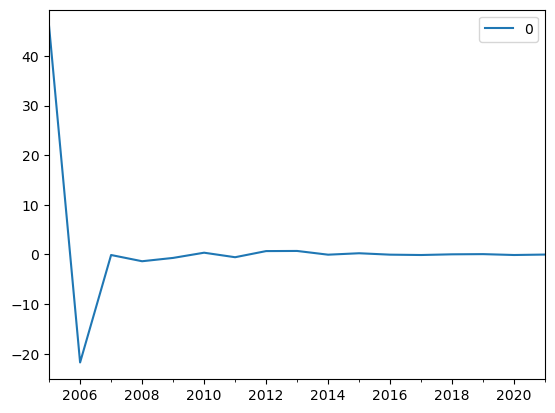

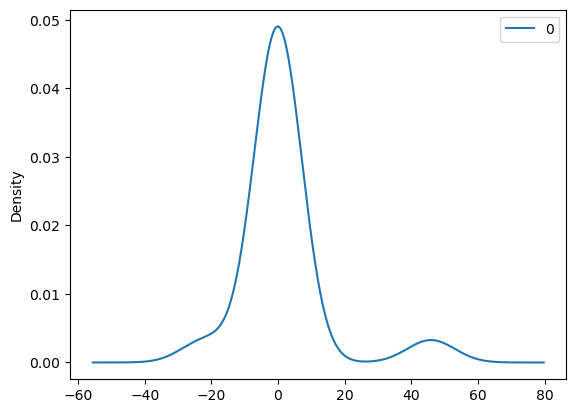

               0
count  17.000000
mean    1.364625
std    12.634955
min   -21.756324
25%    -0.110240
50%    -0.040027
75%     0.243988
max    45.921124


In [74]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
plot_arima_residual_errors(labour_mean_series, arima_order=best_cfg)

Looking pretty good, let's try it on each country

In [75]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

country_arima_orders = {}
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2005', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Find best ARIMA model for each country
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = evaluate_models(country_series, p_values, d_values, q_values)
    country_arima_orders[country] = country_cfg

Best ARIMA(6, 1, 2) MSE=0.214
Best ARIMA(0, 2, 1) MSE=1.237
Best ARIMA(0, 2, 1) MSE=0.108
Best ARIMA(10, 0, 1) MSE=2.159
Best ARIMA(0, 2, 1) MSE=0.232
Best ARIMA(2, 2, 0) MSE=0.229
Best ARIMA(1, 2, 0) MSE=1.208
Best ARIMA(1, 2, 2) MSE=0.452
Best ARIMA(8, 2, 0) MSE=0.441
Best ARIMA(6, 2, 0) MSE=0.061
Best ARIMA(6, 1, 0) MSE=0.497
Best ARIMA(0, 2, 1) MSE=1.168
Best ARIMA(6, 2, 1) MSE=30.503
Best ARIMA(2, 1, 1) MSE=0.595
Best ARIMA(1, 2, 0) MSE=0.182
Best ARIMA(8, 1, 1) MSE=1.725
Best ARIMA(0, 2, 2) MSE=1.896
Best ARIMA(2, 0, 2) MSE=0.329
Best ARIMA(6, 1, 0) MSE=0.808
Best ARIMA(0, 2, 1) MSE=0.067
Best ARIMA(0, 2, 1) MSE=3.588
Best ARIMA(0, 2, 1) MSE=0.576
Best ARIMA(0, 2, 2) MSE=0.193
Best ARIMA(0, 1, 0) MSE=0.195
Best ARIMA(1, 2, 0) MSE=0.535


Draw exponential smoothing vs arima

In [144]:
# Plot Exponential Smoothing vs ARIMA
def plot_exp_smoothing_vs_arima(title, X, arima_order, test_only=False):
    # ARIMA
    results = run_arima_model(X, arima_order)
    train = results["train"]
    train_size = results["train_size"]
    test = results["test"]
    predictions = results["predictions"]

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        X[:train_size],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    if not test_only:
        exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[:train_size])
    
    # Plot graph
    if not test_only:
        # Add the 2016 value to the predictions
        predictions = np.insert(predictions, 0, train[-1])

        plt.plot(index, X, color='black', label='Actual')
        plt.plot(index, exp_forecast, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
        plt.plot(index[train_size-1:], predictions, color='red', label='ARIMA', linestyle='--')
        plt.axvline(x=pd.to_datetime(2016, format="%Y"), color='gray', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2005, 2022)]
        plt.plot(years[train_size:], test, color='black', label='Actual')
        plt.plot(years[train_size:], exp_forecast, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
        plt.plot(years[train_size:], predictions, color='red', label='ARIMA', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

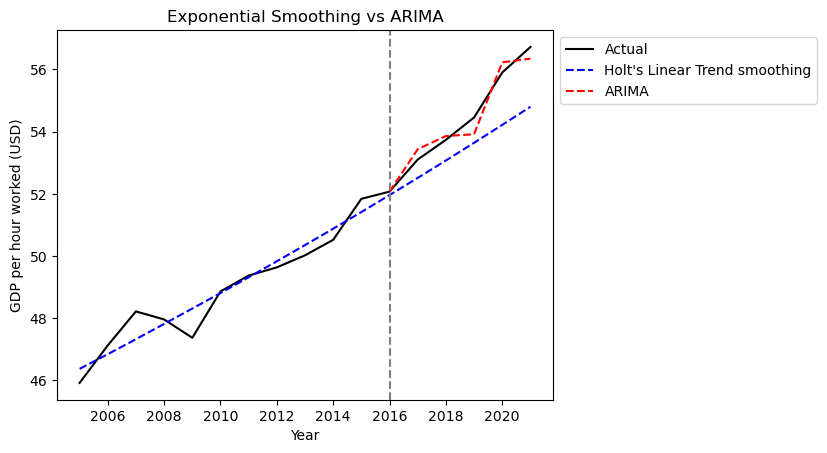

In [145]:
plot_exp_smoothing_vs_arima("Exponential Smoothing vs ARIMA", labour_mean_series, best_cfg)

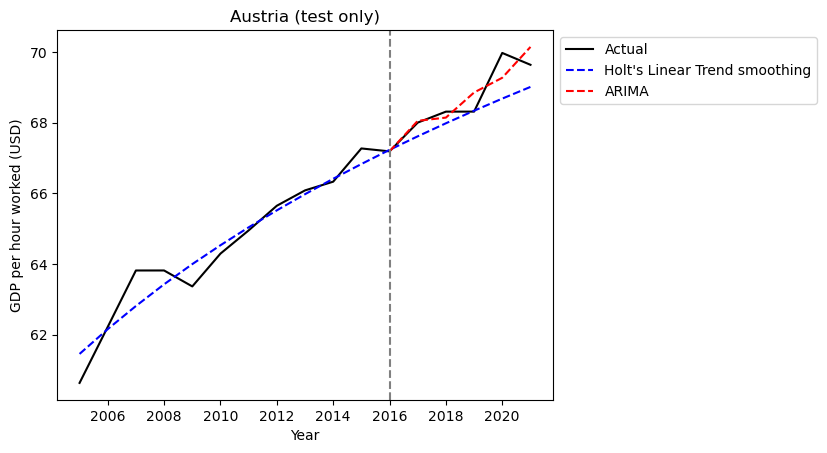

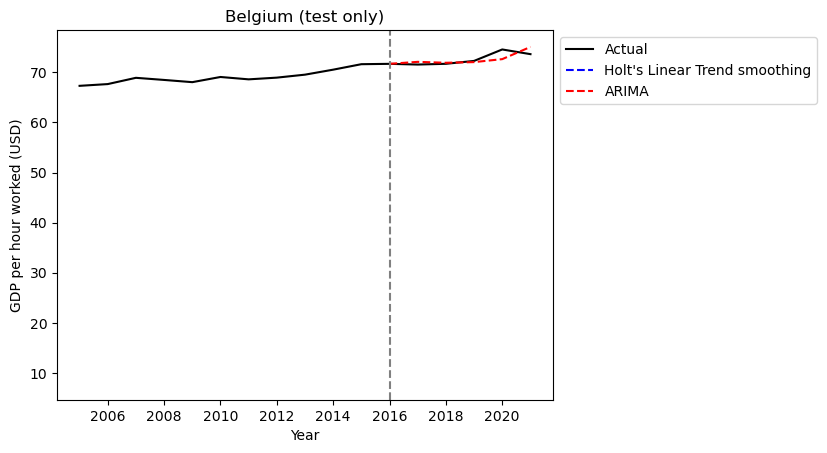

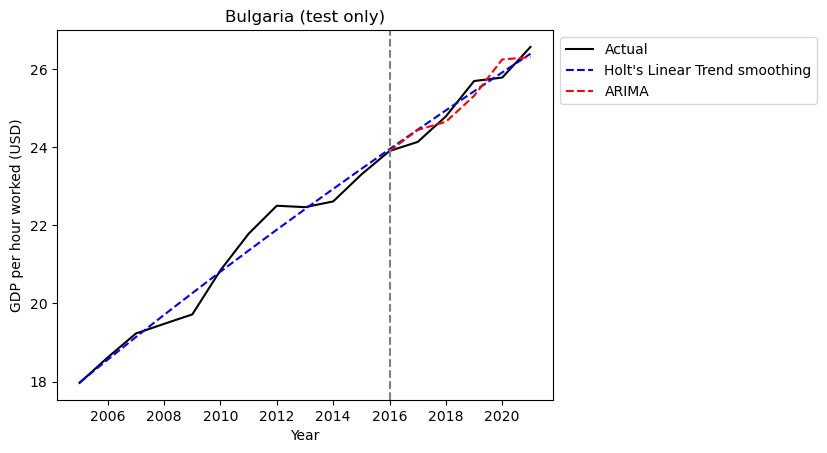

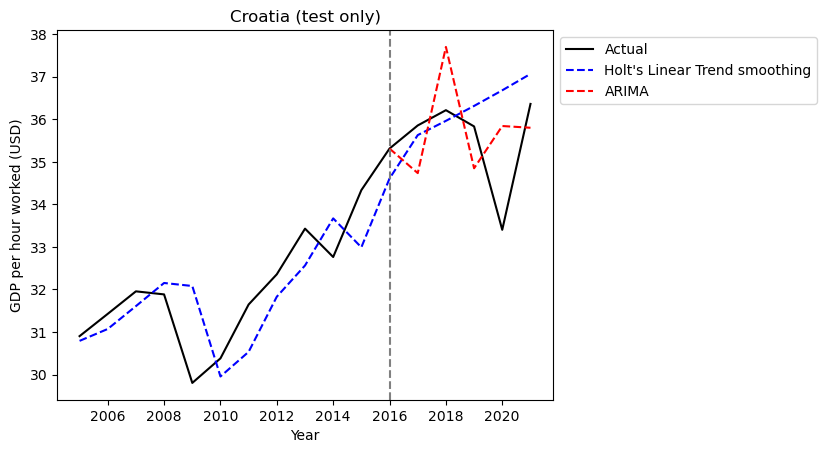

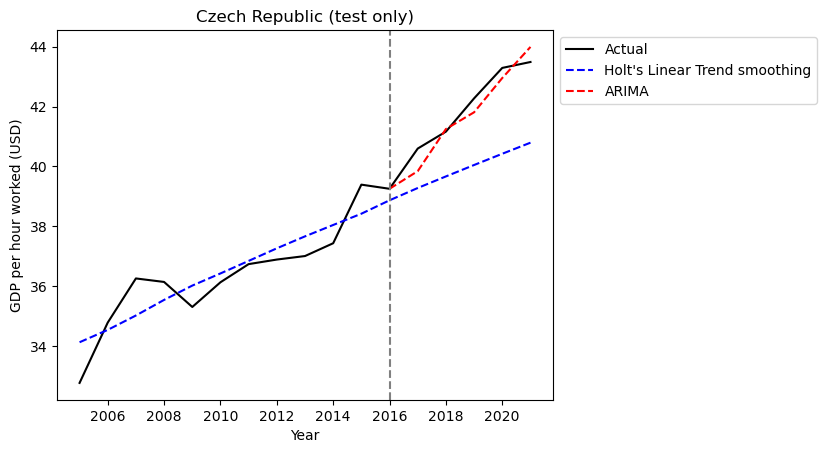

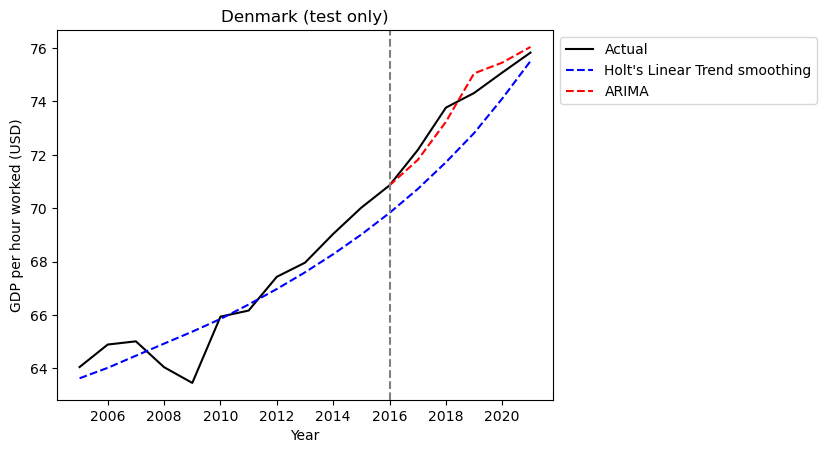

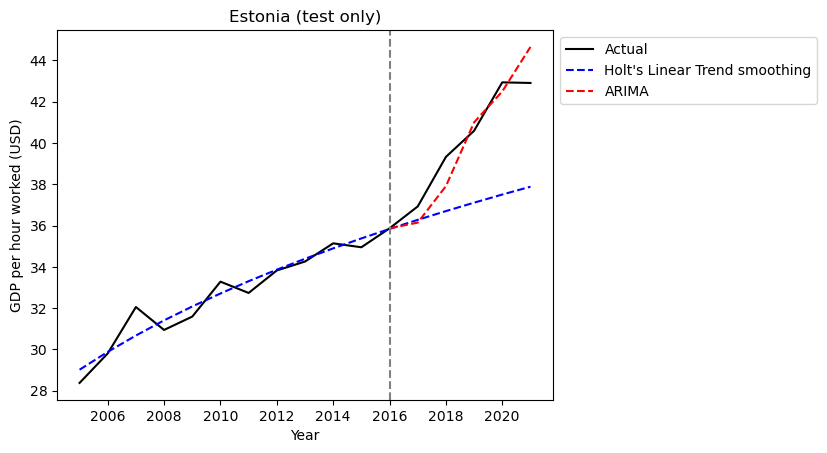

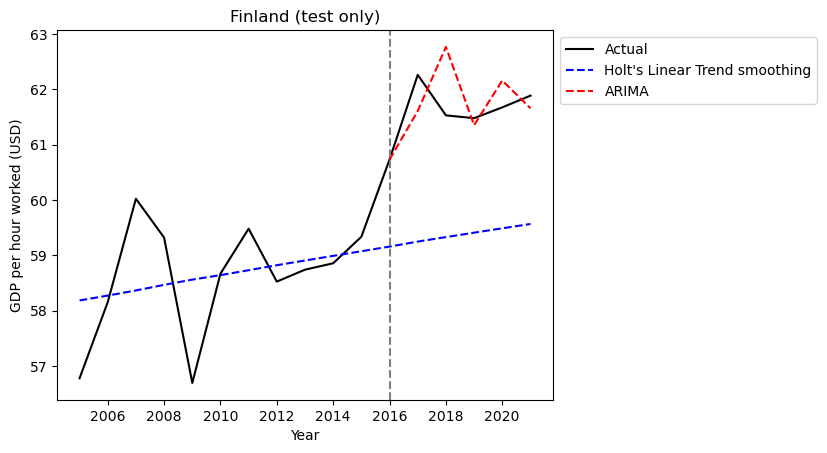

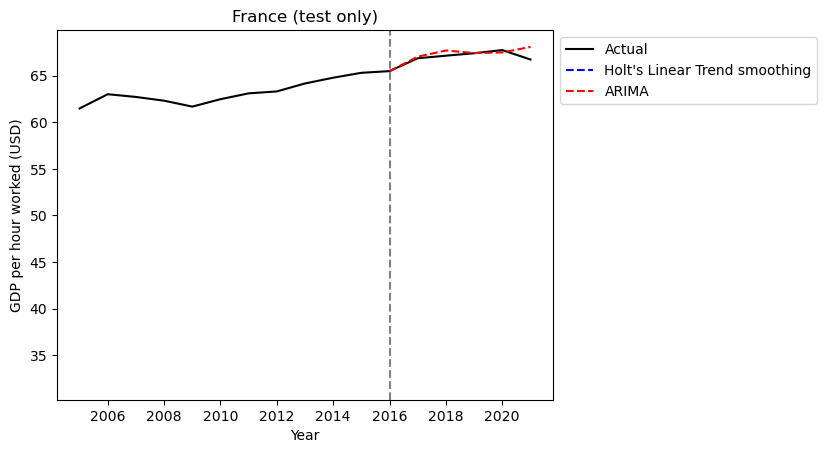

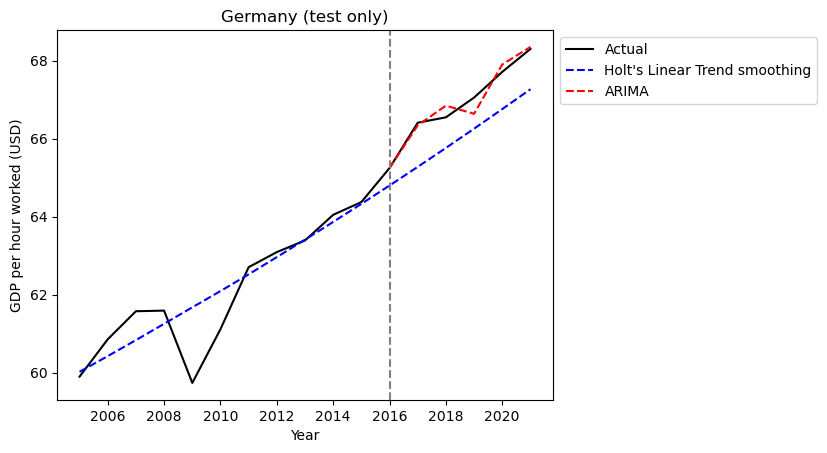

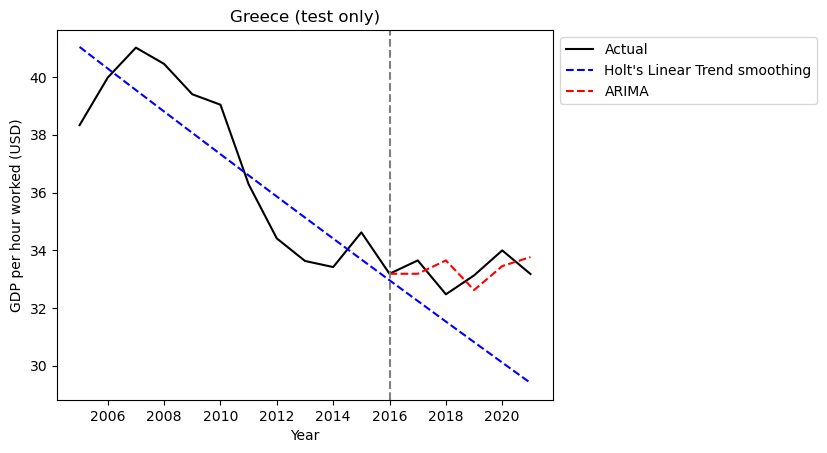

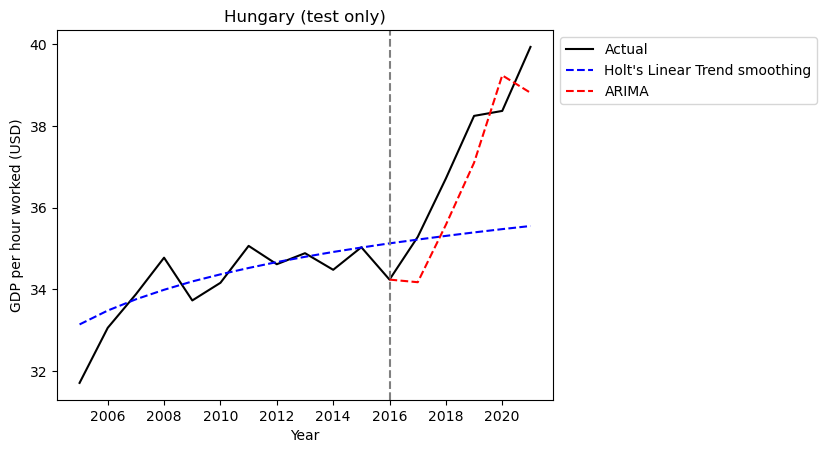

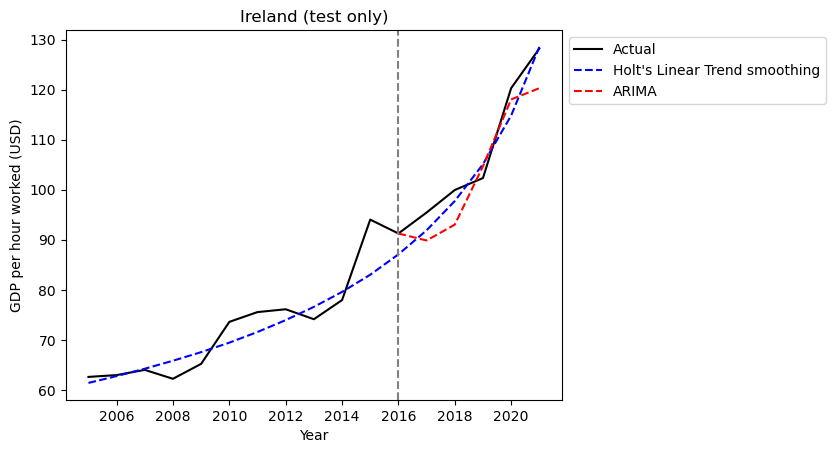

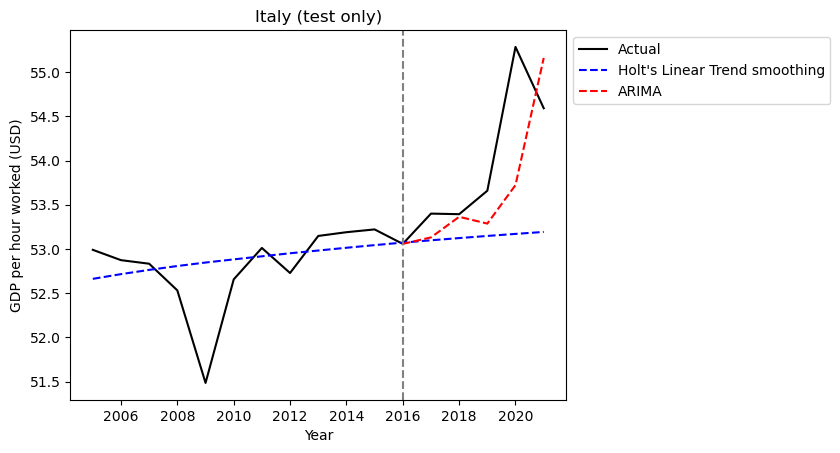

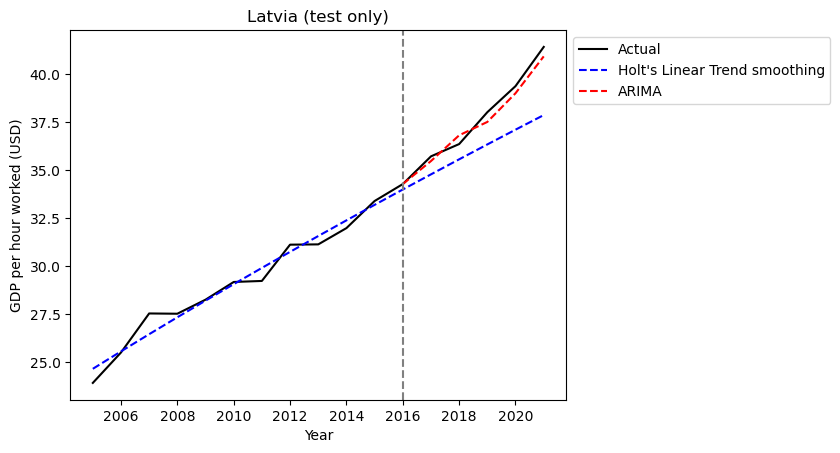

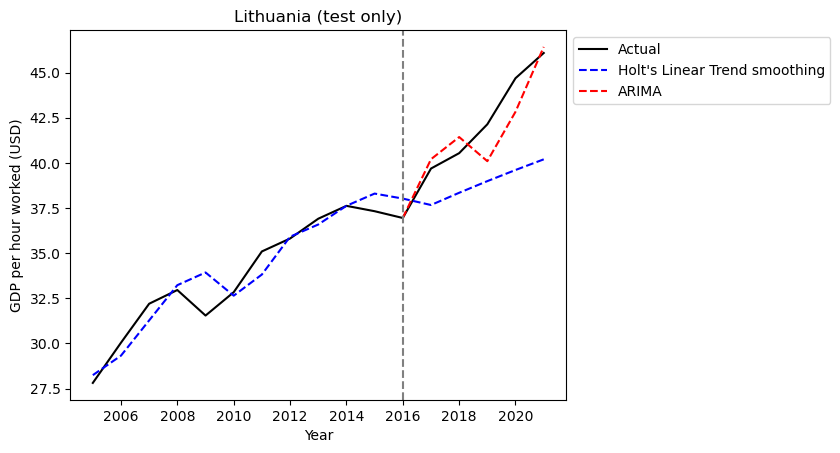

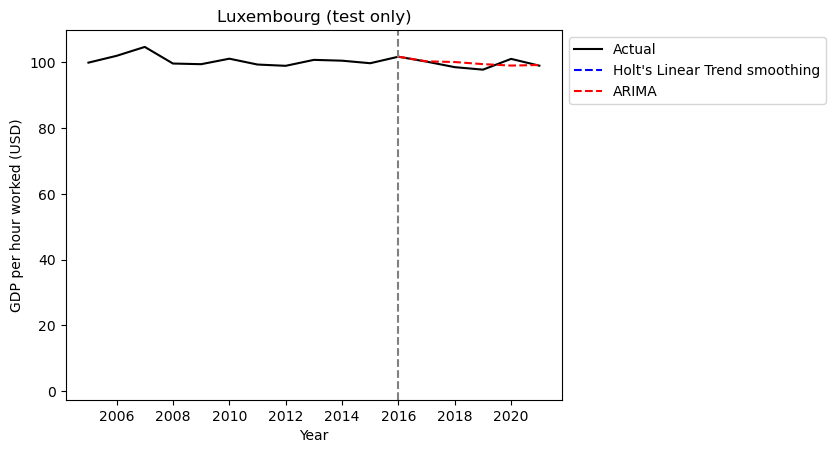

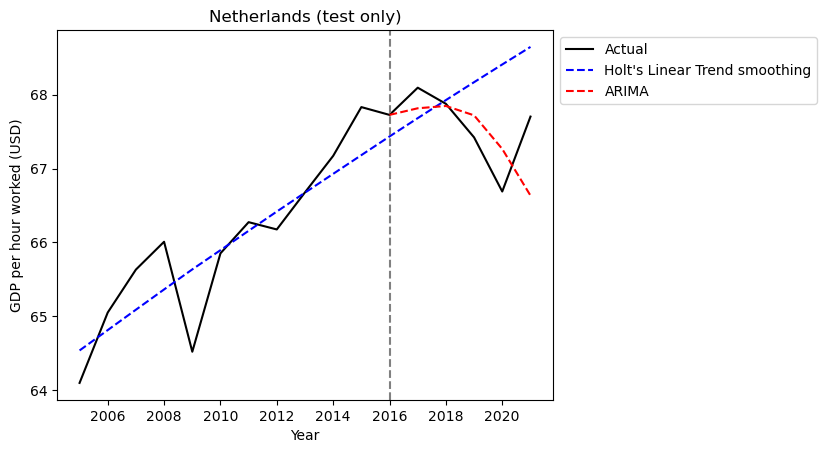

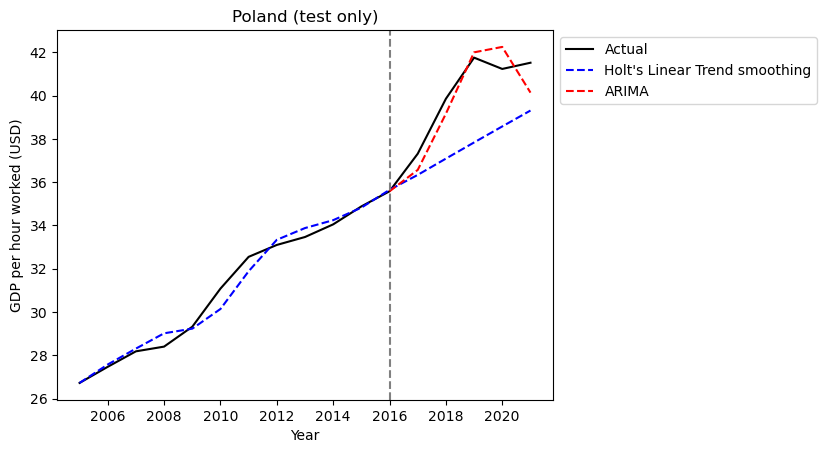

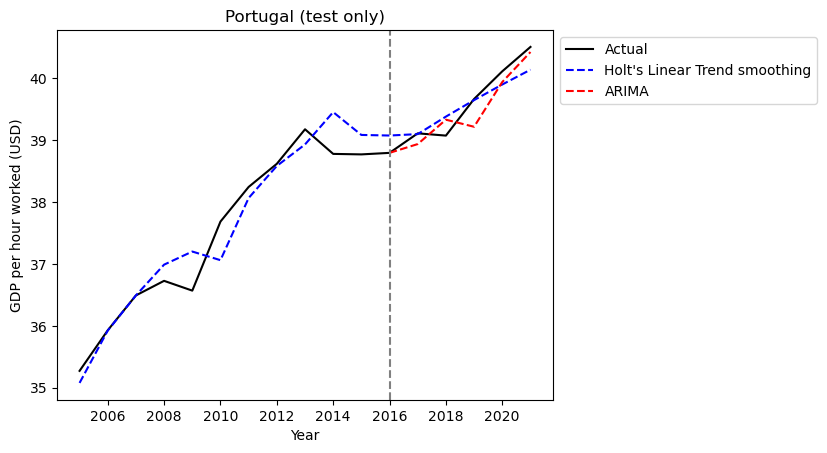

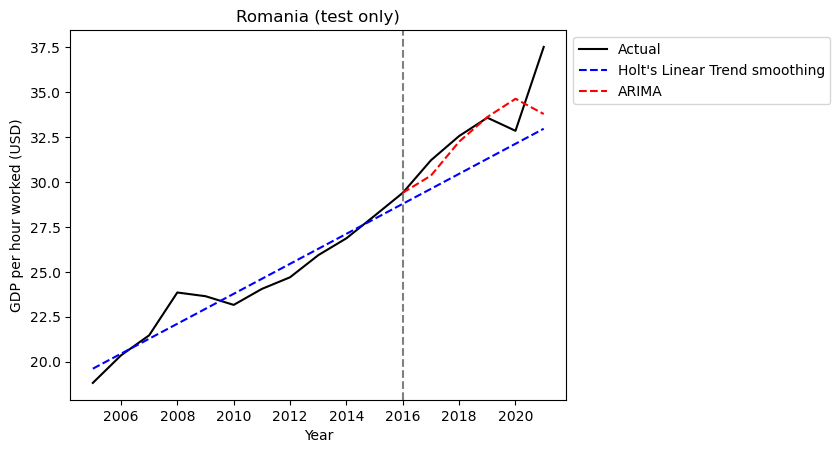

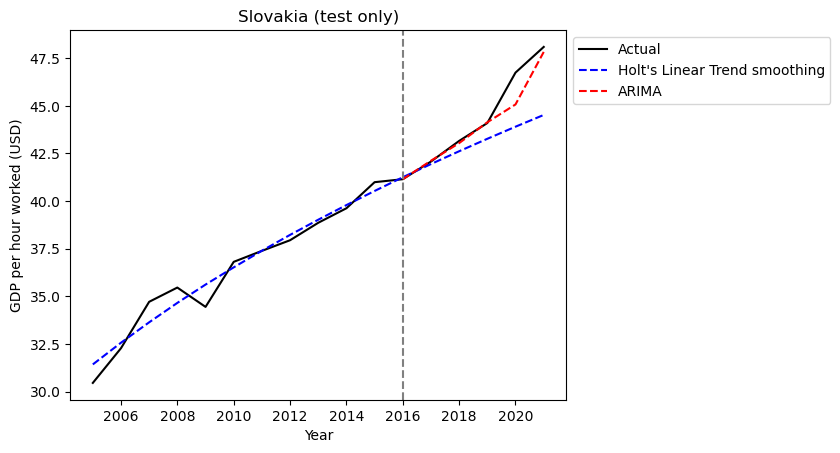

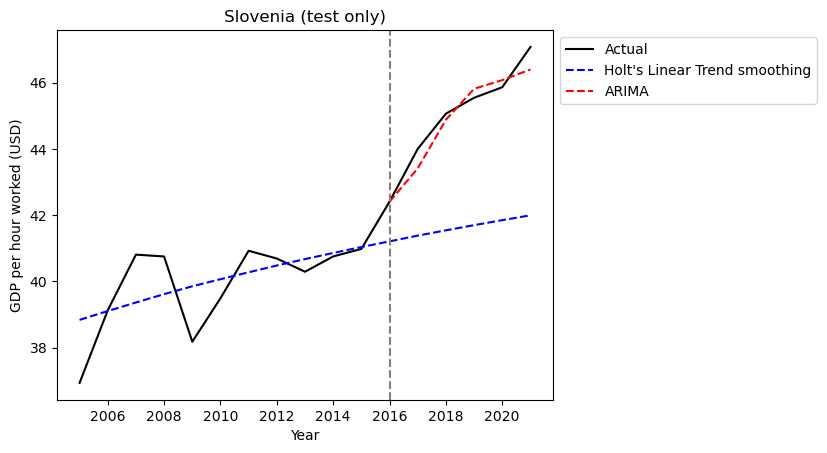

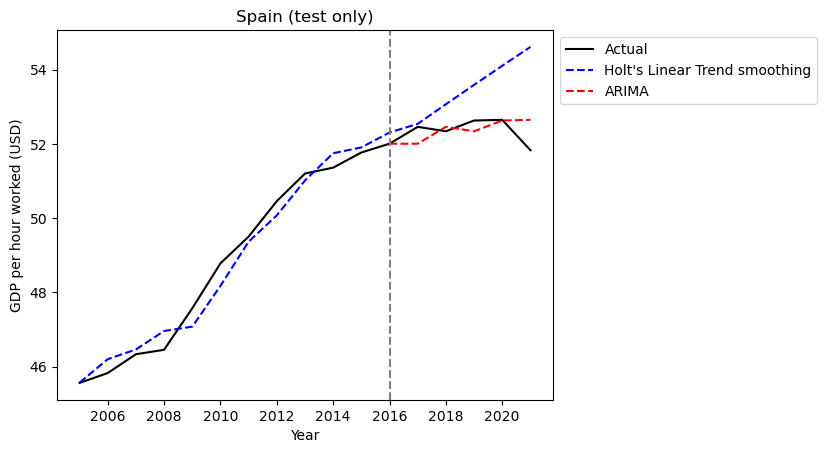

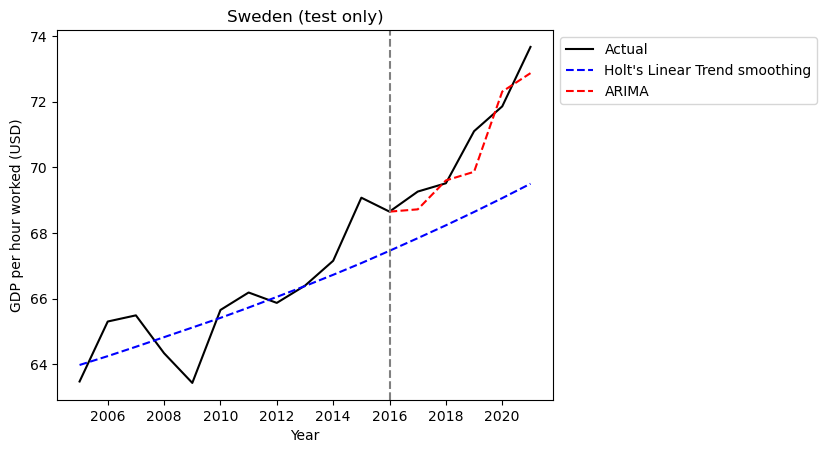

In [146]:
# Plot the data
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2005', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue
    
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = country_arima_orders[country]

    plot_exp_smoothing_vs_arima(country+" (test only)", country_series, country_cfg)

Looks a lot more crazy here, but let's actually run it through some correlation coefficients for a numeric comparison between Exponential Smoothing and ARIMA.
Only going to look at correlation coefficients for the test section for ARIMA

In [112]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'ExpSmooth corr', 'ARIMA corr', 'ExpSmooth RMSE', 'ARIMA RMSE'])
df_results.set_index('Name', inplace=True)

train_size = 2016 - 2005 + 1

def get_correlation_coefficient(actual, pred):
    df = pd.DataFrame({'actual': actual, 'pred': pred})
    return df.corr().iloc[0, 1]

def get_rmse(actual, pred):
    rmse = 0
    for i in range(len(actual)):
        if actual[i] != np.nan and pred[i] != np.nan:
            rmse += (actual[i] - pred[i]) ** 2
    rmse = np.sqrt(rmse / len(actual))

    if rmse == np.inf:
        return np.nan
    return rmse

def get_correlation_for_series(name, series, cfg=best_cfg):
    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:train_size],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_forecast = forecast.values
    exp_corr = get_correlation_coefficient(series[train_size:], exp_forecast)
    exp_rmse = get_rmse(series[train_size:], exp_forecast)

    # ARIMA
    results = run_arima_model(series, cfg)
    predictions = results["predictions"]
    arima_corr = get_correlation_coefficient(series[train_size:], predictions)
    arima_rmse = get_rmse(series[train_size:], predictions)

    df_results.loc[name] = [exp_corr, arima_corr, exp_rmse, arima_rmse]


# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

# Get correlation coefficients for each country
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2005', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    get_correlation_for_series(country, country_series, cfg=country_arima_orders[country])

df_results

,ExpSmooth corr,ARIMA corr,ExpSmooth RMSE,ARIMA RMSE
Name,,,,
Mean,0.990000,0.963041,1.264168,0.364690
Austria,0.873227,0.827635,0.681315,0.463374
Belgium,NaN,0.553143,NaN,1.112290
Bulgaria,0.981137,0.920935,0.218372,0.328804
Croatia,-0.224360,0.100327,1.522639,1.462660
Czech Republic,0.982389,0.964691,2.210335,0.482032
Denmark,0.969132,0.970100,1.388061,0.478246
Estonia,0.971938,0.959704,3.855461,1.099194
Finland,-0.307658,-0.341464,2.381937,0.672417


In [113]:
# Drop first row and get mean of df_results
df_results.mean(axis=0, numeric_only=True)

ExpSmooth corr    0.668153
ARIMA corr        0.607058
ExpSmooth RMSE    2.048997
ARIMA RMSE        0.945607
dtype: float64

Both Exponential smoothing and ARIMA performed poorly, but ARIMA performed better overall

# Per subregions

In [114]:
# Get mean productivity for each subregion per year
subregions_dict = cLib.get_subregions_data()
subregions = cLib.get_subregions()
countries =  cLib.get_countries()
df_subregions = pd.DataFrame(columns=['SUBREGION', 'YEAR', 'PRODUCTIVITY'])
subregion_productivity = {}
for subregion in subregions:
    for year in range(2005, 2022):
        df_toadd = pd.DataFrame({'SUBREGION': subregion, 'YEAR': year, 'PRODUCTIVITY': 0}, index=[0])
        df_subregions = pd.concat([df_subregions, df_toadd], ignore_index=True)

# Fill empty dataframe with mean of productivity for each subregion
for subregion in subregions:
    subregion_productivity[subregion] = {}
    for year in range(2005, 2022):
        subregion_productivity[subregion][year] = 0

for subregion in subregions:
    for country in subregions_dict[subregion]:
        country_code = cLib.get_country_data(country).alpha3
        df_country = df_formatted[df_formatted['LOCATION'] == country_code]
        for year in range(2005, 2022):
            df_toadd = df_country[df_country['YEAR'] == year]
            if not df_toadd.empty:
                subregion_productivity[subregion][year] += df_toadd['PRODUCTIVITY'].values[0]

for subregion in subregions:
    for year in range(2005, 2022):
        mean_val = subregion_productivity[subregion][year] / len(subregions_dict[subregion])
        df_subregions.loc[(df_subregions['SUBREGION'] == subregion) & (df_subregions['YEAR'] == year), 'PRODUCTIVITY'] = mean_val

df_subregions.head()

,SUBREGION,YEAR,PRODUCTIVITY
0,Central Europe,2005,39.875067
1,Central Europe,2006,41.398716
2,Central Europe,2007,42.747381
3,Central Europe,2008,42.990988
4,Central Europe,2009,42.011669


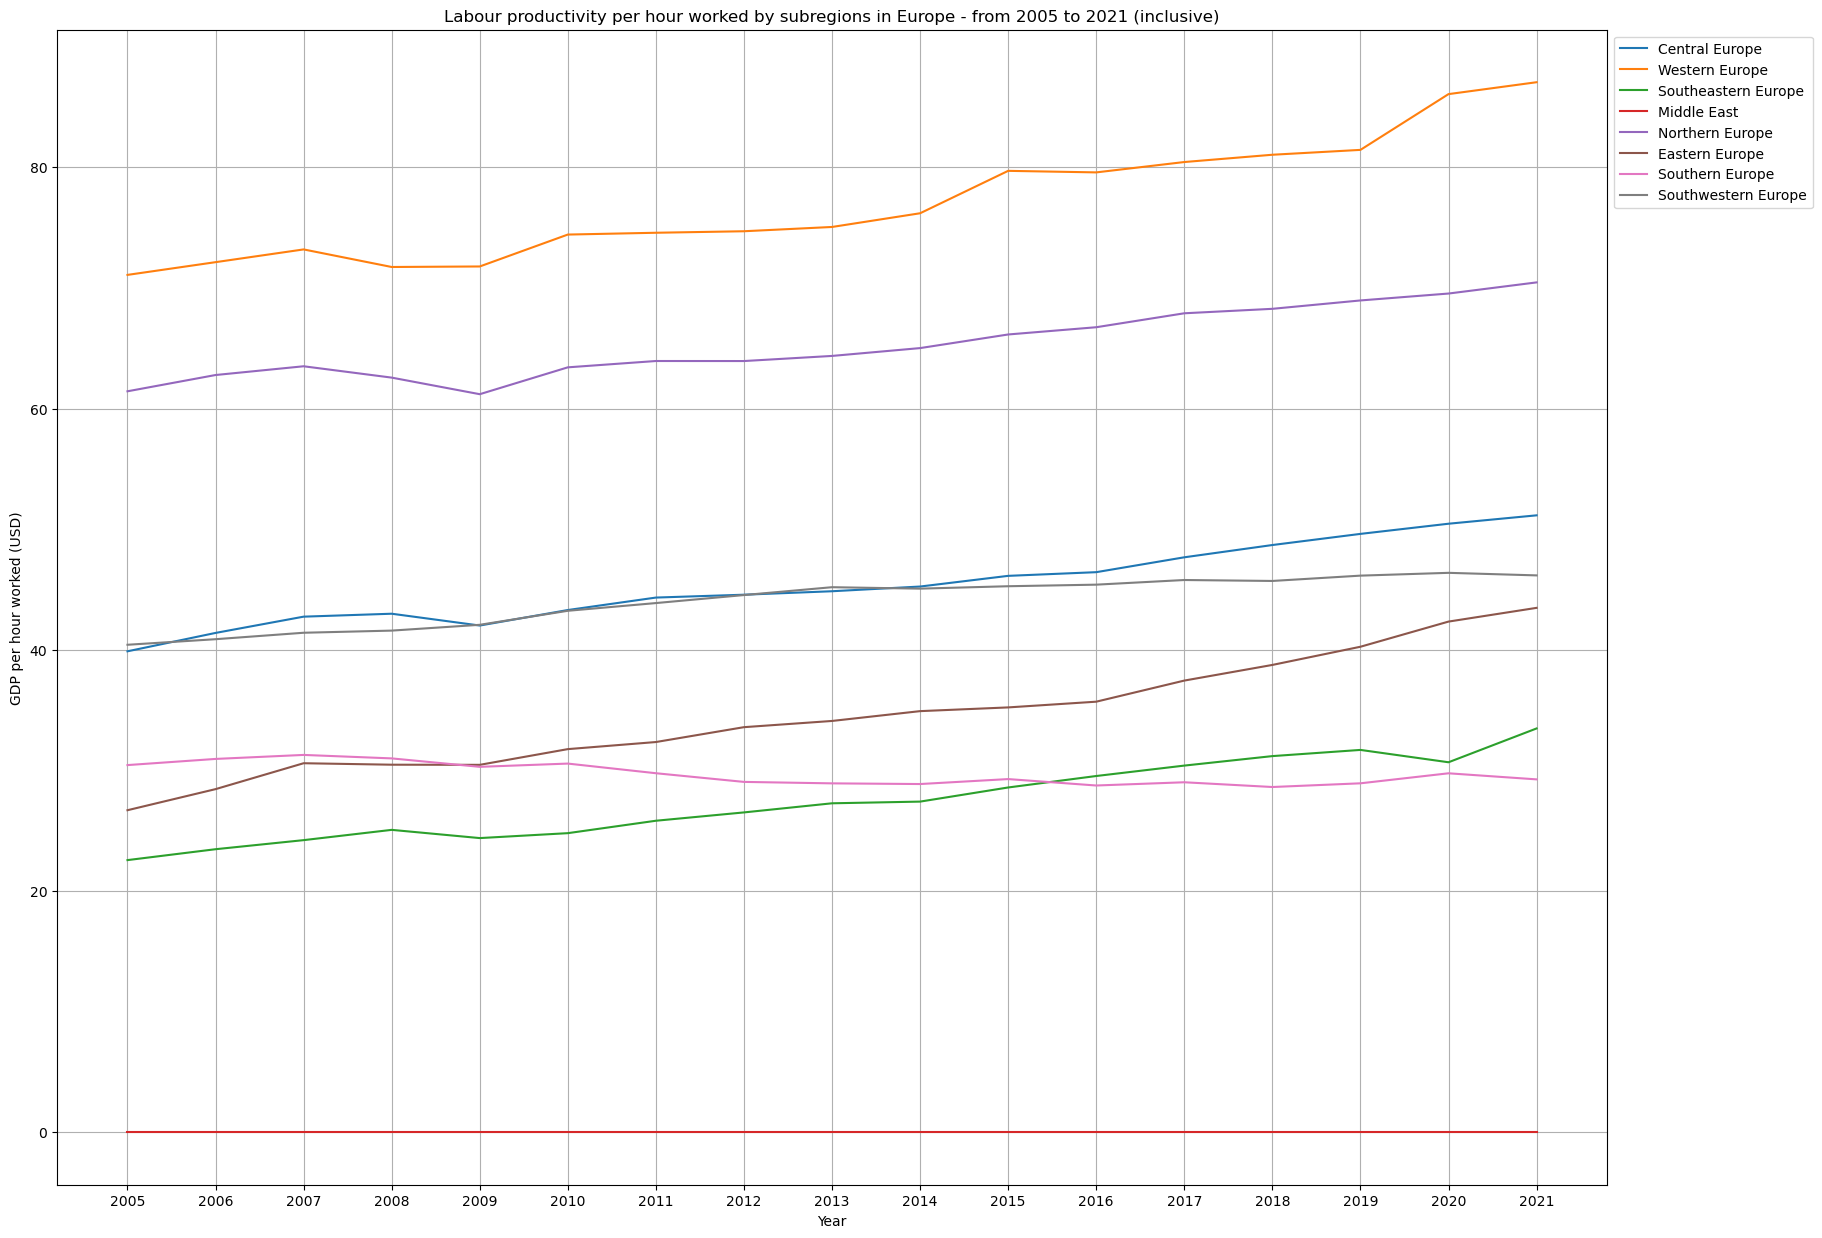

In [118]:
# Plot productivity for each subregion
plt.figure(figsize=(20, 15))
colors = plt.cm.hsv(np.linspace(0, 1, len(subregions)))

for subregion in subregions:
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    plt.plot(df_subregion['YEAR'].astype(str), df_subregion['PRODUCTIVITY'], label=subregion)

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by subregions in Europe - from 2005 to 2021 (inclusive)")
plt.show()

Best ARIMA(1, 2, 2) MSE=0.115


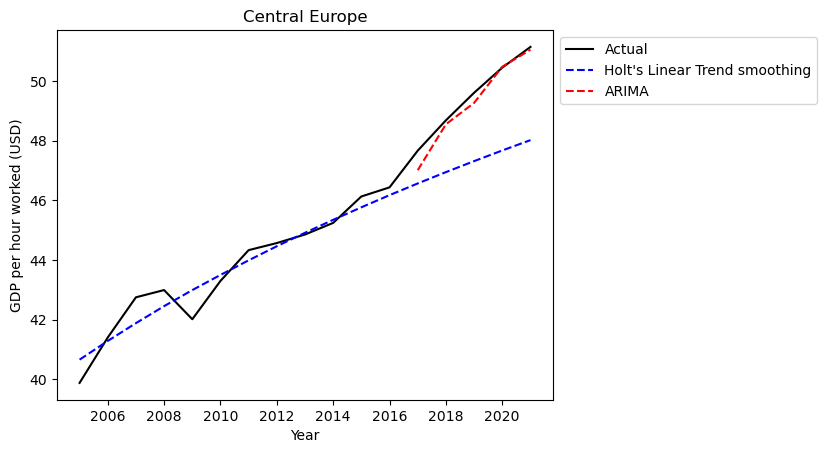

Best ARIMA(6, 1, 0) MSE=1.528


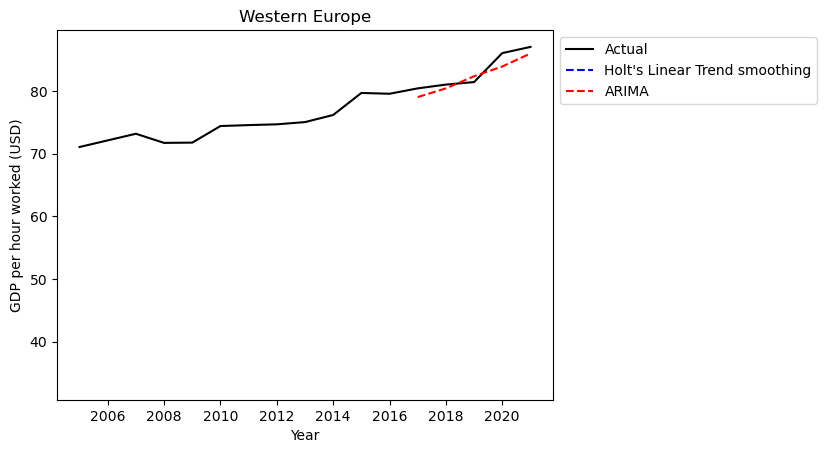

Best ARIMA(0, 2, 1) MSE=1.604


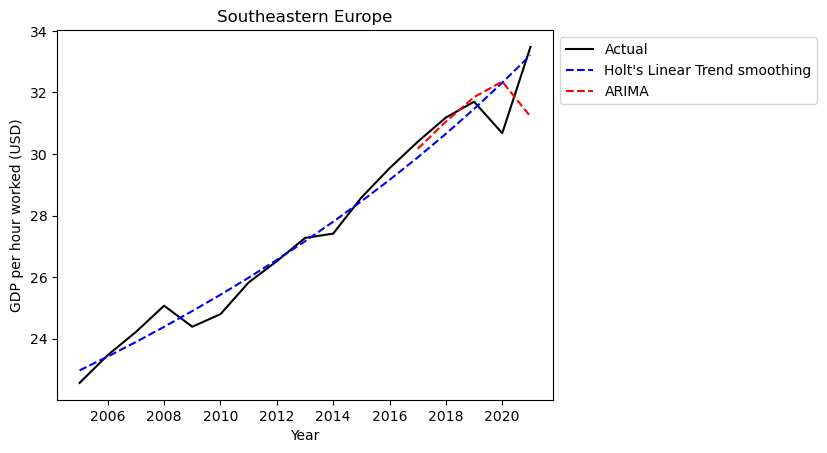

Best ARIMA(0, 2, 1) MSE=0.132


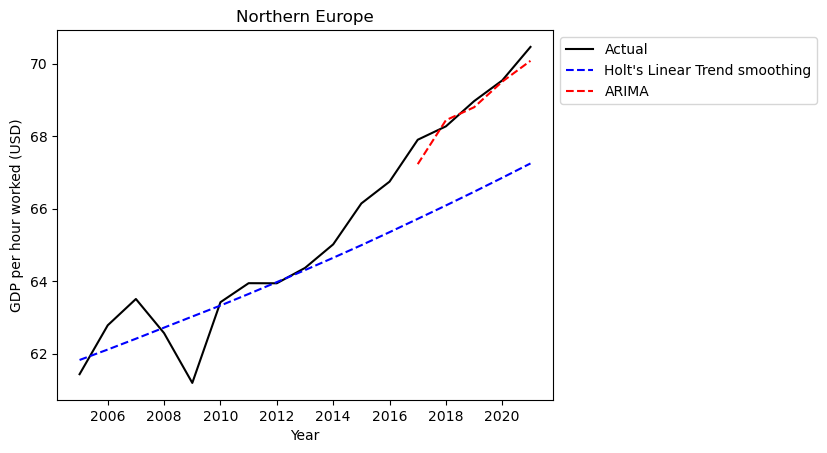

Best ARIMA(1, 2, 2) MSE=0.389


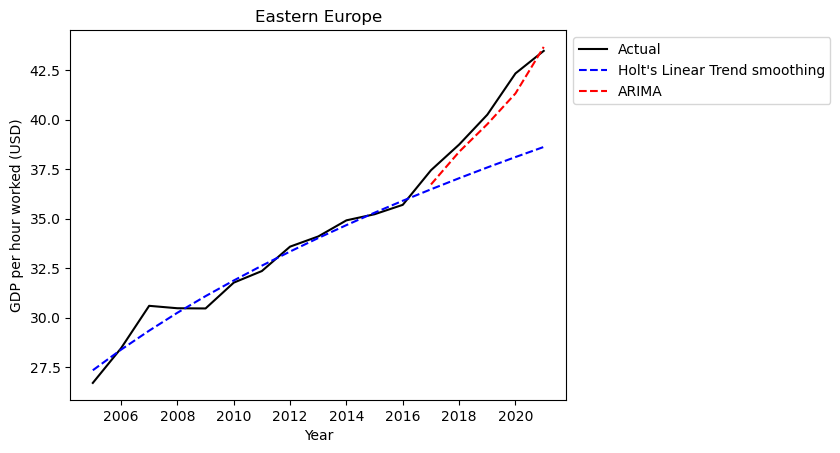

Best ARIMA(1, 0, 0) MSE=0.221


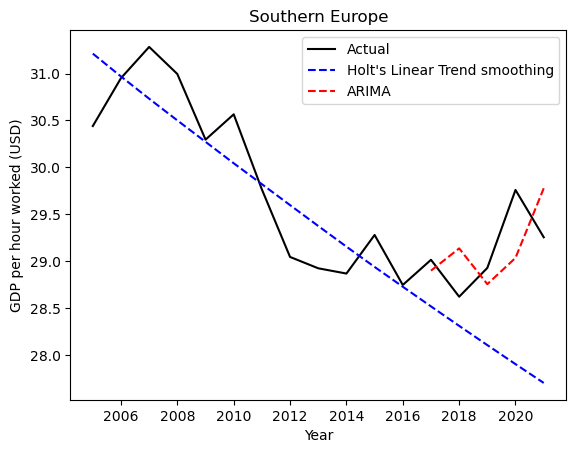

Best ARIMA(0, 1, 0) MSE=0.090


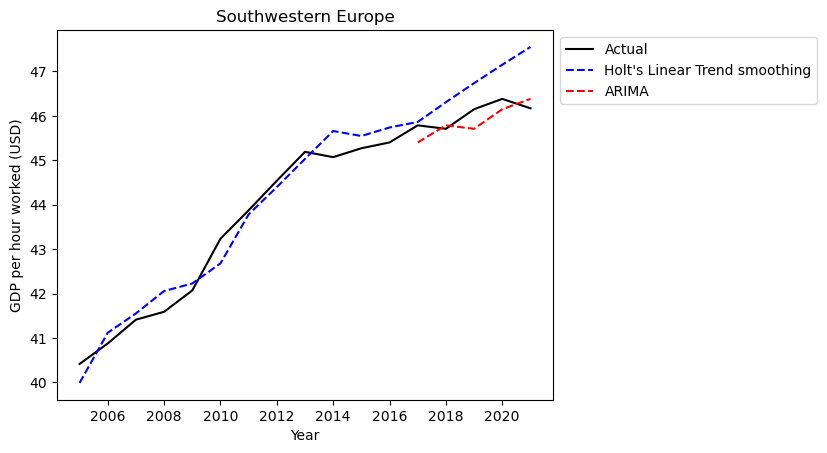

In [116]:
# Predict with both exponential smoothing and ARIMA for each subregion
subregion_arima_orders = {}
for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2005', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')

    # Exponential Smoothing
    try: # Middle East is constant because no data for Cyprus, so ignore it
        fit = ExponentialSmoothing(
            subregion_series,
            trend="add",
            use_boxcox=True,
            initialization_method="estimated"
        ).fit()
    except:
        continue
    forecast = fit.forecast(5)
    exp_forecast = forecast.values

    # ARIMA
    subregion_cfg = evaluate_models(subregion_series, p_values, d_values, q_values)
    subregion_arima_orders[subregion] = subregion_cfg

    # Plot the data
    plot_exp_smoothing_vs_arima(subregion, subregion_series, subregion_cfg)

In [117]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'Exp Smoothing', 'ARIMA'])
df_results.set_index('Name', inplace=True)

# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0 or subregion not in subregion_arima_orders:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')
    get_correlation_for_series(subregion, subregion_series, subregion_arima_orders[subregion])
df_results

ValueError: cannot set a row with mismatched columns

In [ ]:
# Drop first row and get mean of df_results
df_results.drop(df_results.index[0], inplace=True)
df_results.mean()

Exp Smoothing    0.691919
ARIMA            0.778662
dtype: float64

Interestingly it performed a lot better for the subregions, but still not great. It is worth looking at alternative predictive models